In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

TensorFlow 2.x selected.


In [0]:
from google.colab import files
import io
uploaded = files.upload()
df = pd.read_csv(io.BytesIO(uploaded['time_series_covid_19.csv']))


Saving time_series_covid_19.csv to time_series_covid_19 (1).csv


In [0]:
df.head()

,Date,Confrimed,Death,Recovered,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,Unnamed: 32,Unnamed: 33,Unnamed: 34,Unnamed: 35,Unnamed: 36,Unnamed: 37,Unnamed: 38,Unnamed: 39,Unnamed: 40,Unnamed: 41,Unnamed: 42,Unnamed: 43,Unnamed: 44,Unnamed: 45,Unnamed: 46,Unnamed: 47,Unnamed: 48,Unnamed: 49,Unnamed: 50,Unnamed: 51,Unnamed: 52,Unnamed: 53,Unnamed: 54,Unnamed: 55,Unnamed: 56,Unnamed: 57,Unnamed: 58
0,1/22/2020,555,17,28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1/23/2020,653,18,30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1/24/2020,941,26,36,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1/25/2020,1434,42,39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1/26/2020,2118,56,52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

In [0]:
TRAIN_SPLIT = 25

In [0]:
tf.random.set_seed(13)

In [0]:
uni_data = df['Confrimed']
uni_data.index = df['Date']
uni_data.head()

Date
1/22/2020     555
1/23/2020     653
1/24/2020     941
1/25/2020    1434
1/26/2020    2118
Name: Confrimed, dtype: int64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f4b6a949b00>],
      dtype=object)

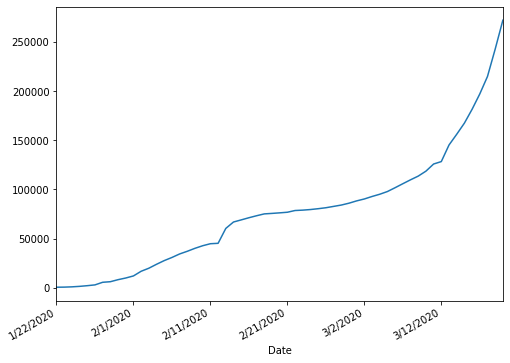

In [0]:
uni_data.plot(subplots=True)

In [0]:
uni_data = uni_data.values
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

In [0]:
uni_data = (uni_data-uni_train_mean)/uni_train_std

In [0]:
univariate_past_history = 20
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

In [0]:
print ('Single window of past history')
print (x_val_uni[0])
print ('\n Target temperature to predict')
print (y_val_uni[0])

Single window of past history
[[0.83145894]
 [0.89587305]
 [0.95534684]
 [0.97127619]
 [0.98894731]
 [1.00877191]
 [1.06438212]
 [1.07660623]
 [1.09570245]
 [1.12246249]
 [1.15356114]
 [1.19659888]
 [1.2398583 ]
 [1.29974378]
 [1.37441854]
 [1.43576079]
 [1.51600923]
 [1.58821383]
 [1.67568274]
 [1.79925395]]

 Target temperature to predict
1.927100429885422


In [0]:
def create_time_steps(length):
  return list(range(-length, 0))

In [0]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

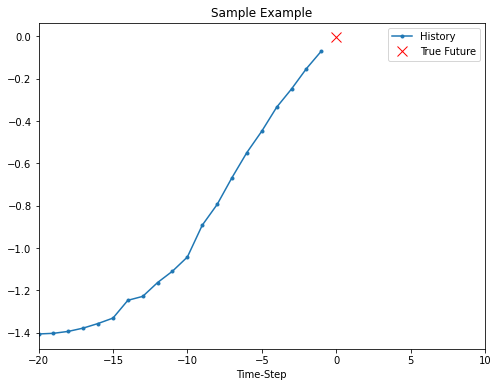

In [0]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

In [0]:
def baseline(history):
  return np.mean(history)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

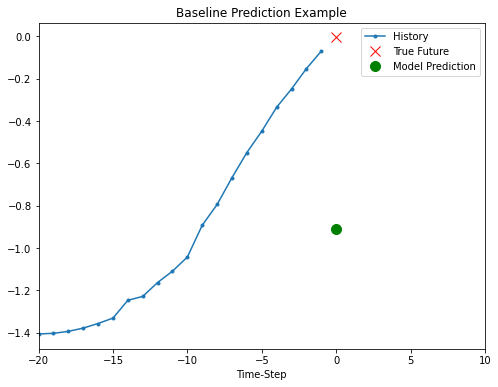

In [0]:
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,
           'Baseline Prediction Example')

In [0]:
BATCH_SIZE = 5
BUFFER_SIZE = 10

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [0]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(1, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

In [0]:
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

(5, 1)


In [0]:
EVALUATION_INTERVAL = 30
EPOCHS = 10

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=10)

Train for 30 steps, validate for 10 steps
Epoch 1/10
30/30 [==============================] - 2s 69ms/step - loss: 0.4193 - val_loss: 4.0936
Epoch 2/10
30/30 [==============================] - 0s 9ms/step - loss: 0.4025 - val_loss: 4.0148
Epoch 3/10
30/30 [==============================] - 0s 9ms/step - loss: 0.3871 - val_loss: 3.9497
Epoch 4/10
30/30 [==============================] - 0s 11ms/step - loss: 0.3720 - val_loss: 3.8985
Epoch 5/10
30/30 [==============================] - 0s 10ms/step - loss: 0.3557 - val_loss: 3.8460
Epoch 6/10
30/30 [==============================] - 0s 9ms/step - loss: 0.3365 - val_loss: 3.7580
Epoch 7/10
30/30 [==============================] - 0s 11ms/step - loss: 0.3118 - val_loss: 3.5595
Epoch 8/10
30/30 [==============================] - 0s 12ms/step - loss: 0.2834 - val_loss: 3.1697
Epoch 9/10
30/30 [==============================] - 0s 12ms/step - loss: 0.2687 - val_loss: 2.7731
Epoch 10/10
30/30 [==============================] - 0s 10ms/step - lo

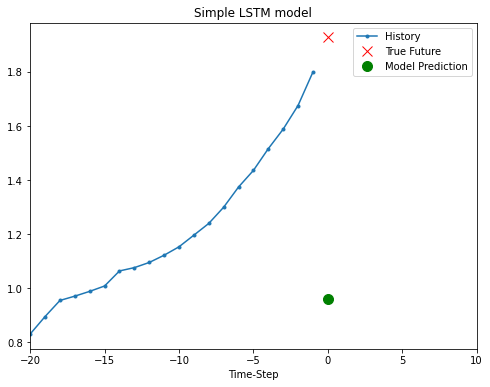

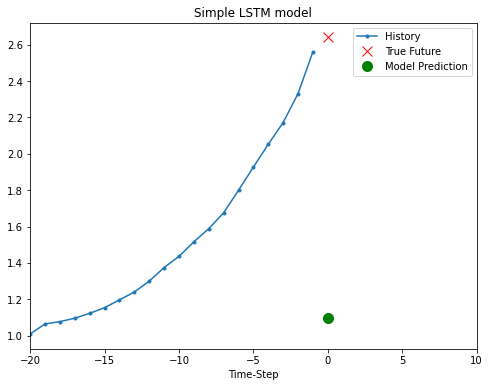

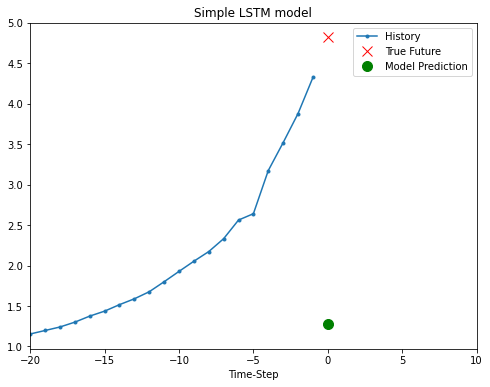

In [0]:
for x, y in val_univariate.take(3):
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
  plot.show()